# PETSc Time-stepping Solver -- PID Control and Steam Example

This example provides an overview of the PETSc time-stepping solver utilities in IDAES, which can be used to solve systems of differential algebraic equations (DAEs). PETSc is a solver suite developed primarily by Argonne National Lab (https://petsc.org/release/). IDAES provides a wrapper for PETSc (https://github.com/IDAES/idaes-ext/tree/main/petsc) that uses the AMPL solver interface (https://ampl.com/resources/learn-more/hooking-your-solver-to-ampl/) and utility functions that allow Pyomo and Pyomo.DAE (https://pyomo.readthedocs.io/en/stable/modeling_extensions/dae.html) problems to be solved using PETSc.

This demonstration uses the IDAES PID controller model and a flowsheet arranged like so:

```
             
->--|><|------[]------|><|-->-
   valve_1   tank   valve_2   
```

where the tank pressure is controlled by the opening of valve_1. 

## Prerequisites

The PETSc solver is an extra download for IDAES.  The solver is available for Linux, but can be run in the Windows environment via the WSL (Windows Subsystem for Linux).  The WSL method of running the solver works smoothly in the normal Windows workflow.  PETSc installation details for Linux and Windows are available along with the documentation (https://idaes-pse.readthedocs.io/en/latest/technical_specs/core/solvers.html).

You may want to review the ["PETSc Time-stepping Solver -- Chemical Akzo Nobel Example"](petsc_chem_example.ipynb) notebook first.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyomo.environ as pyo
import pyomo.dae as pyodae
import idaes.core.solvers.petsc as petsc # petsc utilities module
import pid
from idaes.core.util.math import smooth_max, smooth_min

## Model Set Up

In [2]:
# to see the model code uncomment the line below
#??pid

In [3]:
m = pid.create_model(
    time_set=[0, 12],
    nfe=1,
    calc_integ=True,
)

2022-04-21 14:41:15 [INFO] idaes.init.fs.valve_1: Initialization Complete: optimal - Optimal Solution Found
2022-04-21 14:41:16 [INFO] idaes.init.fs.tank.control_volume: Initialization Complete
2022-04-21 14:41:16 [INFO] idaes.init.fs.tank: Initialization Complete: optimal - Optimal Solution Found
2022-04-21 14:41:16 [INFO] idaes.init.fs.valve_2: Initialization Complete: optimal - Optimal Solution Found


## Solve

In [4]:
result = petsc.petsc_dae_by_time_element(
    m,
    time=m.fs.time,
    ts_options={
        "--ts_type":"beuler",
        "--ts_dt":0.1,
        "--ts_monitor":"", # set initial step to 0.1
        "--ts_save_trajectory":1,
    },
)
tj = result.trajectory # trajectroy data
res = result.results # solver status list

2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)
2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------
2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: DAE: 0
2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\EslickJ\AppData\Local\Temp\tmpih3srkzs.pyomo.nl
2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: Number of constraints: 29
2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 14
2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 15
2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0
2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: Number of variables: 29
2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: Number of integers: 0
2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: Number of binary: 0
2022-04-21 14:41:17 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)
2022-04-21

## Plot Trajectory

At the initial conditions the valve is fully open.  At t=0, the controller is activated and the controller adjusts the opening of valve 1 to keep the tank pressure at the setpoint of 300 kPa.

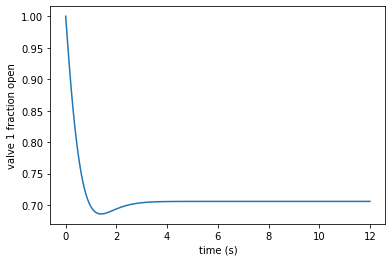

In [5]:
a = plt.plot(tj.time, tj.get_vec(m.fs.valve_1.valve_opening[12]))
a = plt.ylabel("valve 1 fraction open")
a = plt.xlabel("time (s)")

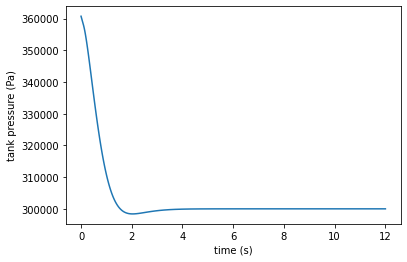

In [6]:
a = plt.plot(tj.time, tj.get_vec(m.fs.tank.control_volume.properties_out[12].pressure))
a = plt.ylabel("tank pressure (Pa)")
a = plt.xlabel("time (s)")

## Model a ramp in inlet pressure

Next we show how to add an explicit time variable and ramp the inlet pressure from 500 kPa to 600 kPa between 10 and 12 seconds.

In [7]:
# Create a new copy of the model that runs to 24 seconds, and add a constraint.

m = pid.create_model(
    time_set=[0, 24],
    nfe=1,
    calc_integ=True,
)
# time_var will be an explicit time variable we can use in constraints.
m.fs.time_var = pyo.Var(m.fs.time)

# We'll add a constraint to calculate the inlet pressure based on time,
# so we need to unfix pressure.
m.fs.valve_1.control_volume.properties_in[0].pressure.unfix()
m.fs.valve_1.control_volume.properties_in[24].pressure.unfix()

# The solver will directly set the time variable for the DAE solve, but
# solving the initial conditions is just a system of nonlinear equations,
# so we need to fix the initial time.
m.fs.time_var[0].fix(m.fs.time.first())

# We could break up the time domain and solve this in pieces, but creative use
# of min and max will let us create the ramping function we want.
# From 10s to 12s ramp inlet pressure from 500,000 Pa to 600,000 Pa
@m.fs.Constraint(m.fs.time)
def inlet_pressure_eqn(b, t):
    return b.valve_1.control_volume.properties_in[t].pressure == \
        smooth_min(600000, smooth_max(500000, 50000*(b.time_var[t] - 10) + 500000))

2022-04-21 14:41:23 [INFO] idaes.init.fs.valve_1: Initialization Complete: optimal - Optimal Solution Found
2022-04-21 14:41:23 [INFO] idaes.init.fs.tank.control_volume: Initialization Complete
2022-04-21 14:41:23 [INFO] idaes.init.fs.tank: Initialization Complete: optimal - Optimal Solution Found
2022-04-21 14:41:23 [INFO] idaes.init.fs.valve_2: Initialization Complete: optimal - Optimal Solution Found


In [8]:
# Solve the new problem.  Notice the new argument specifying the explicit time variable. 
result = petsc.petsc_dae_by_time_element(
    m,
    time=m.fs.time,
    timevar=m.fs.time_var,
    ts_options={
        "--ts_type":"beuler",
        "--ts_dt":0.1,
        "--ts_monitor":"", # set initial step to 0.1
        "--ts_save_trajectory":1,
    },
)
tj = result.trajectory # trajectroy data
res = result.results # solver status list

2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)
2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------
2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: DAE: 0
2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\EslickJ\AppData\Local\Temp\tmph6klz9zy.pyomo.nl
2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: Number of constraints: 30
2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 15
2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 15
2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0
2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: Number of variables: 30
2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: Number of integers: 0
2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: Number of binary: 0
2022-04-21 14:41:24 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)
2022-04-21

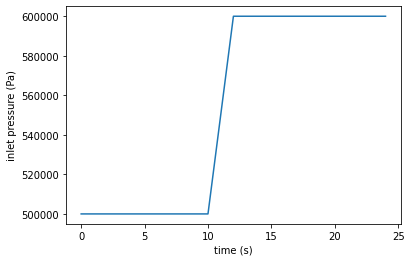

In [9]:
a = plt.plot(tj.time, tj.get_vec(m.fs.valve_1.control_volume.properties_in[24].pressure))
a = plt.ylabel("inlet pressure (Pa)")
a = plt.xlabel("time (s)")

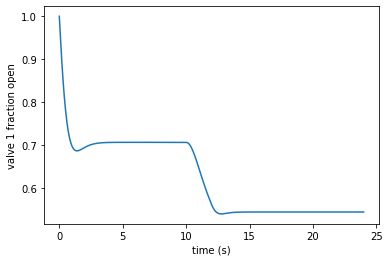

In [10]:
a = plt.plot(tj.time, tj.get_vec(m.fs.valve_1.valve_opening[24]))
a = plt.ylabel("valve 1 fraction open")
a = plt.xlabel("time (s)")

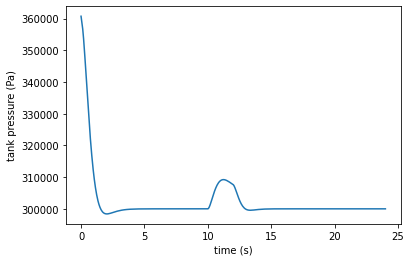

In [11]:
a = plt.plot(tj.time, tj.get_vec(m.fs.tank.control_volume.properties_out[24].pressure))
a = plt.ylabel("tank pressure (Pa)")
a = plt.xlabel("time (s)")

## Model a ramp in inlet pressure (again)

Here we repeat the ramp from the previous simulation in a different way.  In this case we do the integration in three parts. 1) Constant pressure at 500 kPa to 10 s 2) ramp from 500 to 600 kPa from 10 to 12 s. 3) Constant pressure at 600 kPa from 12 to 24 s.

In [12]:
# Create a new copy of the model that runs to 24 seconds, and add a constraint.

m = pid.create_model(
    time_set=[0, 10, 12, 24],
    nfe=3,
    calc_integ=True,
)
# time_var will be an explicit time variable we can use in constraints.
m.fs.time_var = pyo.Var(m.fs.time)

# We'll add a constraint to calculate the inlet pressure from 10 to 12s.  The rest of the
# time pressure will be fixed. For the time section from 10 to 12s, the constraints are
# defined by time 12; this means the pressure at time 12 should be unfixed and the
# pressure constraint should be active.  At all other times, pressure should be fixed and
# the pressure constraint should be deactivated. 
m.fs.valve_1.control_volume.properties_in[0].pressure.fix(500000)
m.fs.valve_1.control_volume.properties_in[10].pressure.fix(500000)
m.fs.valve_1.control_volume.properties_in[12].pressure.set_value(600000)
m.fs.valve_1.control_volume.properties_in[12].pressure.unfix()
m.fs.valve_1.control_volume.properties_in[24].pressure.fix(600000)

@m.fs.Constraint(m.fs.time)
def inlet_pressure_eqn(b, t):
    return b.valve_1.control_volume.properties_in[t].pressure == 50000*(b.time_var[t] - 10) + 500000

m.fs.inlet_pressure_eqn.deactivate()
m.fs.inlet_pressure_eqn[12].activate()

2022-04-21 14:41:35 [INFO] idaes.init.fs.valve_1: Initialization Complete: optimal - Optimal Solution Found
2022-04-21 14:41:35 [INFO] idaes.init.fs.tank.control_volume: Initialization Complete
2022-04-21 14:41:35 [INFO] idaes.init.fs.tank: Initialization Complete: optimal - Optimal Solution Found
2022-04-21 14:41:35 [INFO] idaes.init.fs.valve_2: Initialization Complete: optimal - Optimal Solution Found


In [13]:
# Solve the new problem.  Notice the argument specifying the explicit time variable. 
result = petsc.petsc_dae_by_time_element(
    m,
    time=m.fs.time,
    timevar=m.fs.time_var,
    ts_options={
        "--ts_type":"beuler",
        "--ts_dt":0.1,
        "--ts_monitor":"", # set initial step to 0.1
        "--ts_save_trajectory":1,
    },
)
tj = result.trajectory # trajectroy data
res = result.results # solver status list

2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: Called fg_read, err: 0 (0 is good)
2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: ---------------------------------------------------
2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: DAE: 0
2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: Reading nl file: C:\Users\EslickJ\AppData\Local\Temp\tmppt0psclb.pyomo.nl
2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: Number of constraints: 29
2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: Number of nonlinear constraints: 14
2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: Number of linear constraints: 15
2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: Number of inequalities: 0
2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: Number of variables: 29
2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: Number of integers: 0
2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: Number of binary: 0
2022-04-21 14:41:36 [INFO] idaes.solve.petsc-dae: Number of objectives: 0 (Ignoring)
2022-04-21

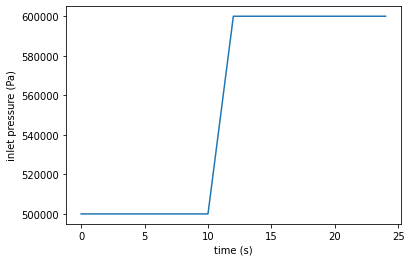

In [14]:
a = plt.plot(tj.time, tj.get_vec(m.fs.valve_1.control_volume.properties_in[24].pressure))
a = plt.ylabel("inlet pressure (Pa)")
a = plt.xlabel("time (s)")

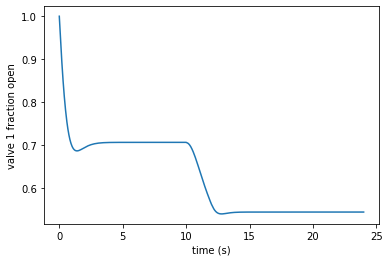

In [15]:
a = plt.plot(tj.time, tj.get_vec(m.fs.valve_1.valve_opening[24]))
a = plt.ylabel("valve 1 fraction open")
a = plt.xlabel("time (s)")

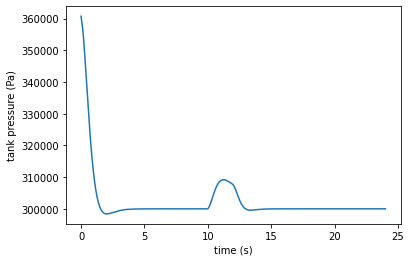

In [16]:
a = plt.plot(tj.time, tj.get_vec(m.fs.tank.control_volume.properties_out[24].pressure))
a = plt.ylabel("tank pressure (Pa)")
a = plt.xlabel("time (s)")